# Deep Learning for NLP - Project

## Implementation of Importance Sampling and NCE

### Team Members
    - Mohammed LANSARI
    - Imad BOUHOU
    - Ihsan ULLAH
    - Ousmane CISSE
    
***

# Download data :
To run this notebook in Google Colab, we download the data from Google Drive and the uncompress it.

In [ ]:
#!gdown --id 1R3K-vRKde5jfuZRYS7aoMBBdceX20BOW
#!unzip -q data_nlp.zip

# Imports

In [ ]:
import time
import torch
import itertools
torch.cuda.empty_cache()

import gc
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.nn.utils import clip_grad_norm_ , rnn
from torch.distributions.categorical import Categorical

We use cuda if it is available otherwise we use cpu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Read Data

### Data Path

In [ ]:
data_path = "data/"

path_test = data_path + "ptb.test.txt"
path_train = data_path + "ptb.train.txt"
path_valid = data_path + "ptb.valid.txt"

### Reading file function
This function reads a file from its path line by line, removes extra spaces from start and end of each line and stores the text as a list of sentences 

In [ ]:
def read_file(path):
    """
    Function to read the texts from the data
    parameters :
                - path : path to the file
    return :
            - returns a list of sentences 
    """
    sentences = list()
    with open(path) as f :
        for line in f:
            line.strip()
            if len(line) != 0:
                sentences.append(line.split())
    return sentences

### Vocabulary class to store and access data
Vocabulary class is used to store vocabulary in two forms:
   - word to index
   - index to words
   
Each word is mapped to a unique index. and each index is mapped back to a unique word. a counter is also kept to track the length of the vocabulary. No duplicate word is added to the vocabulary.

In [ ]:
class vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.count = 0
    
    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.count
            self.idx2word[self.count] = word
            self.count = self.count + 1

    def get_word(self , index):
        return self.idx2word[index]

    def get_index(self , word):
        return self.word2idx[word]
      
    def __len__(self):
        return self.count

### Read Train, Valid, Test data

In [ ]:
train_data = read_file(path_train)
valid_data = read_file(path_valid)
test_data = read_file(path_test)

### Create vocabulary from Training data
The vocabulary is created from the training data and additional two words i.e. *< bos >* and *< eos >* are added to the vocabulary.

In [ ]:
vocab = vocabulary()
for sentence in train_data:
    for word in sentence:
        vocab.add_word(word)
    
vocab.add_word("<bos>")
vocab.add_word("<eos>")

### Convert data to Tensors
This function is used to convert a sentence to a Pytorch Tensor.

Each sentence represents words in the form of numbers i.e. the unique indices. Before conversion into Tensor, the index of **< bos >** is concatinated at the start and index of **< eos >** to the end of the sentence.

In [ ]:
def sentence_to_tensor(sentence):
    """
    Function to transform the sentences to tensors
    parameters :
                - sentence : list of integers (words)
    return :
            - returns an equivalent tensor to the sentence
    """
    sentence = [vocab.get_index(word) for word in sentence]
    bos = vocab.get_index("<bos>")
    eos = vocab.get_index("<eos>")
    full_sentence = [bos] + sentence + [eos]
    return torch.tensor(full_sentence)

### Extracting sentences and their masks from data
Because all sentences do not have equal number of words, we have to add zero padding before giving them as inputs to the model. To make sure that we do not compute gradients for the padded part of the sentence, we create masks for each sentence. The masks have True values for the actual part of sentence and False values for the padded part of the sentence.

In [ ]:
# Training sentences and masks
train_sentences = [sentence_to_tensor(train_data[j]) for j in range(len(train_data))]
train_masks = [torch.ones_like(train_sentences[i]) for i in range(len(train_sentences))]

# Validation sentences and masks
valid_sentences = [sentence_to_tensor(valid_data[j]) for j in range(len(valid_data))]
valid_masks = [torch.ones_like(valid_sentences[i]) for i in range(len(valid_sentences))]

# Test sensentes and masks
test_sentences = [sentence_to_tensor(test_data[j]) for j in range(len(test_data))]
test_masks = [torch.ones_like(test_sentences[i]) for i in range(len(test_sentences))]

# Compute Frequencies of each word :
We compute frequencies for each word in the vocabulary. We also normalizes the frequencies

In [ ]:
indexes, freqs = np.unique(
    np.concatenate([s.numpy() for s in train_sentences]),
    return_counts=True
    )

freqs = freqs/np.sum(freqs)

# Hyper parameters
We define hyper-parameters to be used for training the Language Model

In [ ]:
vocab_size = len(vocab)
embed_size = 128
hidden_size = 128
num_layers = 1
num_epochs = 50
batch_size = 512

Cross Entropy Loss to check performance of the model

In [ ]:
CE_loss = nn.CrossEntropyLoss()

# Create a batch of data

In [ ]:
def get_batch(data , masks , batch_size):
    """
    Function to yields batchs for the training
    parameters :
                - data : list of tensors
                - masks : binary masks for each sentence to know the 
                          original words before padding.
                - batch_size : the batch size to use
    return :
            - returns a tuple (inputs , targets , mask_out)
            - inputs : the sentences of the input.
            - targets : the target labels.
            - mask_out : the mask associated with the targets.
    """
    
    # loop over data with an interval of batch_size
    for i in range(0, len(data)-batch_size, batch_size):
        
        # extract a input batch from start index to the batch_size index
        s = data[i:(i+batch_size)]
        
        # extract a mask batch from start index to the batch_size index
        s_mask = masks[i:(i+batch_size)]

        # pad the inputs with the value = vocab size
        # because 0 is used as an index for the first word in the vocabulary
        inputs = rnn.pad_sequence(s, batch_first = True, padding_value = vocab_size)
        
        # pad the mask with default value = 0/False
        mask_tensor = rnn.pad_sequence(s_mask, batch_first = True).type(torch.bool)
        
        # create targets which are the next words for each input
        targets = inputs[: , 1:]
        # create mask fro targets
        mask_out = mask_tensor[: , 1:]
        
        # remove the last word from inputs
        inputs = inputs[: , :-1]

        
        # set to a device
        inputs, targets, mask_out = inputs.to(device), targets.to(device), mask_out.to(device)
        
        yield (inputs , targets , mask_out)

# Model

In [ ]:
class lm(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, initialise_bias = False):
        super(lm, self).__init__()
        
        # Create an embedding layer
        self.embed = nn.Embedding(vocab_size + 1, 
                                  embed_size, 
                                  padding_idx = vocab_size)
        
        # Create LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        
        # Create linear layer
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        # initialize bias of the linear layer with parameters of the Unigram
        if initialise_bias:
            self.linear.bias.data = torch.tensor(np.log(freqs + 1e-10))
        
    def forward(self, x):
        
        # get embeddings of x
        x = self.embed(x)
        
        # get output from LSTM
        out, _ = self.lstm(x)
        
        # apply linear transformation
        out = self.linear(out)
        
        return out

# Importance Sampling Loss

**Loss Function**  
$    \frac{\partial}{\partial \theta} log P_{\theta}(w|S) \approx \frac{\partial}{\partial \theta} f_{\theta}(w,S) - \frac{1}{k} \frac{1}{Z_{\theta}(S)} 
    \sum \limits_{\underset{\hat{w_i} \sim Q}{i=1}}^k \frac{exp(f_{\theta}(\hat{w_i},S))}{Q(\hat{w_i})} \frac{\partial}{\partial \theta} f_{\theta}(\hat{w_i},S)
$

**Partition Function $Z$**  
$
Z_{\theta}(S) \approx \frac{1}{k} \sum \limits_{\underset{\hat{w_i} \sim Q}{i=1}}^k \frac{exp(f_{\theta}(\hat{w_i},S))}{Q(\hat{w_i})}
$


In [ ]:
class ImportanceSamplingLoss(nn.Module):
    def __init__(self, Q, Ns=500):
        super(ImportanceSamplingLoss, self).__init__()
        
        # initialize the noise distribution Q
        self.Q = Q  
        
        # initialize number of samples (to be used in approximation)
        self.Ns = Ns 
        
    def forward(self, outputs, targets):
        
        bs = outputs.size(0) 
        
        
        rows = torch.tensor( [list(range(bs))] * self.Ns)
        rows = torch.transpose(rows , 0  , 1)

        # sample from the Noise distribution Q
        # Ns * bs because for each word in batch, we want Ns samples
        wi = self.Q.sample(torch.Size([self.Ns * bs]))
        
        # Get probability for w_i
        q  = self.Q.probs[wi].to(device)
        
        # Reshape the sample and probability
        wi = wi.reshape(-1,self.Ns)
        q  = q.reshape(-1,self.Ns)

        # Compute Z = Sum_k(exp(s_theata)/q)
        Z = (torch.exp(outputs[rows, wi])/q).mean(-1)

        # Sample from Q 
        wi = self.Q.sample(torch.Size([self.Ns * bs]))
        # Get probability of w_i
        q  = self.Q.probs[wi].to(device)
        
        # Reshape the sample and probability
        wi = wi.reshape(-1,self.Ns)
        q  = q.reshape(-1,self.Ns)
        
        # Compute the first term in the Sum over k in the loss
        cte  = torch.exp(outputs[rows ,wi])/q
        
        # Combine the terms inside the sum over k in the loss
        cte1 = (cte.detach() * outputs[rows ,wi]).mean(-1)  

        rows = torch.tensor(list(range(bs)))
        
        # compute the first term of the loss
        out  = outputs[rows,targets]
        
        # combine all the terms in the loss
        loss = - (out - cte1/Z.detach()).mean()
        
        
        return loss, torch.log(Z)

# NCE Loss

$
\frac{\partial}{\partial \theta} J_{\theta}(w) = \frac{kQ(w)}{p_{\theta}(w|S) + kQ(w)} \frac{\partial}{\partial \theta} \log p_{\theta}(w|S) - \sum_{i=1}^k \Big{[} \frac{p_{\theta}(\hat{w_i}|S)}{p_{\theta}(\hat{w_i}|S) + kQ(\hat{w_i})} \frac{\partial}{\partial \theta} \log p_{\theta}(\hat{w_i} | S) \Big{]} 
$



In [ ]:
class NCELoss(nn.Module):
    def __init__(self, Q, Ns=100, train_partition = False, log_Z = 0.0):
        super(NCELoss, self).__init__()
        
        # initialize the noise distribution Q
        self.Q = Q
        
        # initialize number of samples (to be used in approximation)
        self.Ns = Ns
        
        # true when we want to train Z as a parameter
        if train_partition:
            self.log_Z = nn.Parameter(torch.tensor([float(log_Z)]))
        else : 
            self.log_Z = torch.tensor([0.0]).to(device)
        
    def forward(self, outputs, targets):
        
        bs = outputs.size(0)      
        
        outputs = outputs - self.log_Z
        
        rows = torch.tensor( [list(range(bs))])
        
        # compute exponential of score function:  p_theta = exp(s_theta)
        exp_out = torch.exp(outputs[rows,targets]).reshape(-1)
        
        # sample from the Noise distribution Q
        # Ns * bs because for each word in batch, we want Ns samples
        wi = self.Q.sample(torch.Size([ self.Ns * bs ]))
        
        # Get probability for w_i
        q = self.Q.probs[wi].to(device)
        
        # Reshape the sample and probability
        wi = wi.reshape(-1,self.Ns)
        q = q.reshape(-1,self.Ns)
        

        rows = torch.tensor( [list(range(bs))] * self.Ns)
        rows = torch.transpose(rows , 0  , 1)

        
        # compute the numerator of the first term of loss = kQ(w)
        kP_n = self.Ns * self.Q.probs[targets].to(device)
        
        # compute the first term of loss = [kQ(w)/ (kQ(w)+p_theta)] * log(p_theta) 
        first_term = (kP_n/(kP_n + exp_out )).detach() * torch.log( exp_out )

        # compute the numerator inside the sum of second term of loss
        s_exp = torch.exp(outputs[rows,wi])
        
        # compute the full last term of the loss = Sum_k (p_theta/(p_theta + k*q))*log(p_theta)
        second_term = ( (s_exp/(s_exp + self.Ns * q)).detach()*torch.log(s_exp)).sum(-1)
        
        # combine the first and second terms of loss
        loss = -(first_term - second_term).mean()
        
        return loss, self.log_Z

# Negative Sampling Loss

$
J_{\theta} = - \Big{[} \log \sigma (s_{\theta} (w,S)) + \sum_{i=1}^k \log \sigma (-s_{\theta}(\hat{w_i},S) ) \Big{]}
$

In [ ]:
class NEGLoss(nn.Module):
    def __init__(self, Q, Ns=100):
        super(NEGLoss, self).__init__()
        
        # initialize the noise distribution Q
        self.Q = Q
        
        # initialize number of samples (to be used in approximation)
        self.Ns = Ns
        
        # we do not want to compute log_Z
        self.log_Z = torch.tensor([0.0]).to(device)
 
    def forward(self, outputs, targets):
        
        
        bs = outputs.size(0)      
        rows = torch.tensor( [list(range(bs))])

        # sample from the Noise distribution Q
        # Ns * bs because for each word in batch, we want Ns samples
        wi = self.Q.sample(torch.Size([self.Ns * bs]))
        
        # Get probability for w_i
        q  = self.Q.probs[wi].to(device)
        
        # Reshape the sample and probability
        wi = wi.reshape(-1,self.Ns)
        q  = q.reshape(-1,self.Ns)

        # Compute the first term of Negative sampling loss = log(sigmoid(s_theta))
        loss_first = torch.log(torch.sigmoid(outputs[rows , targets]))

        rows = torch.tensor( [list(range(bs))] * self.Ns)
        rows = torch.transpose(rows, 0, 1)

        # Compute the second term of the loss = sum over k log(sigmoid(-s_theta))
        loss_second = torch.log(torch.sigmoid(-outputs[rows, wi])).sum(-1)
        
        #combine the 1st and 2nd terms of the loss
        loss = -(loss_first + loss_second).mean()
        
        return loss, self.log_Z

# Testing Function

In [ ]:
def test(model):

    print("\n==================================")
    print("Test")
    print("==================================")
    
    # put model in evaluation mode
    model.eval()
    
    # start time
    start = time.time()
    cross_entropy_losses = []
    
    # loop over test batches
    for (step , batch) in enumerate(get_batch(test_sentences, test_masks , batch_size)):
        
        # get batch of inputs , targets and masks
        inputs , targets , mask_in = batch
        
        # output from forward function of model
        outputs = model(inputs)

        # remove padded part of outputs
        outputs = outputs[mask_in]
        targets = targets[mask_in]

        # compute and store cross-entropy loss
        ce_loss = CE_loss(outputs , targets).item()
        cross_entropy_losses.append(ce_loss)

    # compute duration of testing
    duration = (time.time() - start )/60  
    
    # compute cross-entropy for the test set
    test_cross_entropy_loss = np.mean(cross_entropy_losses)

    print('Perplexity: {:5.2f}'.format( np.exp(test_cross_entropy_loss)) , end = '')
    print(', CE {:.4f}'.format(test_cross_entropy_loss) , end = '')
    print(', Duration :{:5.2f}'.format(duration))

# Training Function

In [ ]:
def train(model , optimizer , train_loss , full_data ):
    
    train_sentences, train_masks , batch_size = full_data
    
    # set model in train mode
    model.train()
    
    # define lists to keep cross_entropy loss and Sum(Z)
    ce_losses = []
    sum_over_z = []
    
    # loop over epochs
    for epoch in range(num_epochs):
        
        # start execution time
        start = time.time()
        
        # list to store cross-entropy loss for one epoch
        ce_loss_per_epoch = []
        
        # loop over batches in data
        for (step , batch) in enumerate(get_batch(train_sentences, train_masks , batch_size)):
            
            # get batch of inputs , targets and masks
            inputs , targets , mask_in = batch
            
            # Calling model's forward function
            outputs = model(inputs)

            # remove padded part of the output
            outputs = outputs[mask_in]
            targets = targets[mask_in]

            # compute the training loss and partition function
            loss, log_Z = train_loss(outputs, targets)

            # keep the cross-entropy loss 
            ce_loss_per_epoch.append(CE_loss(outputs , targets).item())

            # backpropagation of loss
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
        
        # compute the duration of one epoch
        duration = (time.time() - start )/60  
        
        # store cross-entropy loss of each epoch
        ce_losses.append(np.mean(ce_loss_per_epoch)) 
        
        # store Sum over Z to check if it is close to 1
        sum_over_z.append((torch.exp(outputs).sum(-1)/torch.exp(log_Z)).mean().item())

        print('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'
                    .format(epoch+1, num_epochs, loss.item(), np.exp(ce_losses[-1])) , end = '')
        print(', CE {:.4f}'.format(ce_losses[-1]) , end = '')
        print(', Normalization 1 ?= :{:5.2f}'.format(sum_over_z[-1]), end = '')
        print(', Duration :{:5.2f}'.format(duration))
        
    test(model)
    return model, ce_losses, sum_over_z

# Function to generate text :

In [ ]:
def generate_text(model, Q , sen_length = 20):
    
    # set model in evaluation mode
    model.eval()
    
    # initialize variables for text generation
    generated_text = ''
    generated_word = ''

    # initialize start word from distribution Q
    start_word = Q.sample(torch.Size([1])).to(device)
    
    # reshape start word
    start_word = torch.unsqueeze(start_word, 0)

    
    iterr = 0
    with torch.no_grad():
        
        # loop until <eos> is generated or if a sentence of size sen_length is generated
        while (generated_word != '<eos>') and (iterr < sen_length):
            
            # output from model with input = start word
            generated_word_index = model(start_word)
            
            # take argmax of the output to get output index
            generated_word_index = torch.argmax(generated_word_index, -1).item()

            # get the word for output index from vocabulary
            generated_word = vocab.get_word(generated_word_index)
            
            # add the generated word to the generated text
            generated_text +=  ' ' + generated_word

            # change the start word to the current generated word
            start_word = torch.tensor([[generated_word_index]]).to(device)
            
            # increment the iterator
            iterr += 1
            
    return generated_text

***
***
# **Experiments**
***
***

## Importance sampling with unigram (non-uniform) proposal distribution

In [ ]:
Q = Categorical(torch.tensor(freqs))
model = lm(vocab_size, embed_size, hidden_size, num_layers).to(device)
is_loss = ImportanceSamplingLoss(Q = Q).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(is_loss.parameters()), lr= 1e-4)
model, is_ce_non_uni, is_non_uni_part = train(model,
                                              optimizer,
                                              is_loss,
                                              (train_sentences, train_masks , batch_size) )
for _ in range(5):
    print('--------------------------')
    print(generate_text(model , Q))

Epoch [1/50], Loss: -0.1906, Perplexity: 9384.17, CE 9.1468, Normalization 1 ?= : 1.01, Duration : 2.55
Epoch [2/50], Loss: -1.3025, Perplexity: 2981.57, CE 8.0002, Normalization 1 ?= : 1.00, Duration : 2.56
Epoch [3/50], Loss: -0.3747, Perplexity: 870.20, CE 6.7687, Normalization 1 ?= : 1.00, Duration : 2.54
Epoch [4/50], Loss: -0.1397, Perplexity: 719.05, CE 6.5779, Normalization 1 ?= : 1.00, Duration : 2.54
Epoch [5/50], Loss: -0.0952, Perplexity: 698.33, CE 6.5487, Normalization 1 ?= : 1.00, Duration : 2.55
Epoch [6/50], Loss: -0.1192, Perplexity: 686.77, CE 6.5320, Normalization 1 ?= : 1.00, Duration : 2.58
Epoch [7/50], Loss: -0.1754, Perplexity: 673.27, CE 6.5121, Normalization 1 ?= : 1.00, Duration : 2.59
Epoch [8/50], Loss: -0.2027, Perplexity: 657.74, CE 6.4888, Normalization 1 ?= : 1.00, Duration : 2.53
Epoch [9/50], Loss: -0.2234, Perplexity: 642.45, CE 6.4653, Normalization 1 ?= : 1.00, Duration : 2.53
Epoch [10/50], Loss: -0.2337, Perplexity: 626.96, CE 6.4409, Normalizat

## Importance sampling with uniform proposal distribution

In [ ]:
Q = Categorical(torch.zeros(vocab_size) + 1/vocab_size)
model = lm(vocab_size, embed_size, hidden_size, num_layers).to(device)
is_loss = ImportanceSamplingLoss(Q = Q).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(is_loss.parameters()), lr= 1e-4)
model, is_ce_uni ,is_uni_part = train(model,
                                      optimizer,
                                      is_loss, 
                                      (train_sentences, train_masks , batch_size))

for _ in range(5):
    print('--------------------------')
    print(generate_text(model , Q))

Epoch [1/50], Loss: -0.2355, Perplexity: 9214.60, CE 9.1285, Normalization 1 ?= : 1.00, Duration : 2.95
Epoch [2/50], Loss: -1.3548, Perplexity: 2821.85, CE 7.9451, Normalization 1 ?= : 1.02, Duration : 2.94
Epoch [3/50], Loss: -0.2414, Perplexity: 864.88, CE 6.7626, Normalization 1 ?= : 1.15, Duration : 2.95
Epoch [4/50], Loss: -0.0953, Perplexity: 722.98, CE 6.5834, Normalization 1 ?= : 1.16, Duration : 2.95
Epoch [5/50], Loss: -0.2008, Perplexity: 707.43, CE 6.5616, Normalization 1 ?= : 1.16, Duration : 2.95
Epoch [6/50], Loss: -0.1982, Perplexity: 697.55, CE 6.5476, Normalization 1 ?= : 1.16, Duration : 2.94
Epoch [7/50], Loss: -0.3027, Perplexity: 687.46, CE 6.5330, Normalization 1 ?= : 1.16, Duration : 2.94
Epoch [8/50], Loss: -0.2935, Perplexity: 677.24, CE 6.5180, Normalization 1 ?= : 1.16, Duration : 2.94
Epoch [9/50], Loss: -0.3642, Perplexity: 667.73, CE 6.5039, Normalization 1 ?= : 1.16, Duration : 2.94
Epoch [10/50], Loss: -0.4327, Perplexity: 658.26, CE 6.4896, Normalizat

## NCE with unigram (non-uniform) proposal distribution and $log(Z_c) = 0$ (not trainable)

In [ ]:
Q = Categorical(torch.tensor(freqs))
model = lm(vocab_size, embed_size, hidden_size, num_layers).to(device)
nce_loss = NCELoss(Q = Q , train_partition = False, log_Z = 0).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(nce_loss.parameters()), lr= 1e-3)
model, nce_ce_non_uni ,nce_non_uni_part = train(model,
                                                optimizer,
                                                nce_loss, 
                                                (train_sentences, train_masks , batch_size))

for _ in range(5):
    print('--------------------------')
    print(generate_text(model , Q))

Epoch [1/50], Loss: -0.2675, Perplexity: 4937.92, CE 8.5047, Normalization 1 ?= : 1.08, Duration : 0.65
Epoch [2/50], Loss: -0.0639, Perplexity: 719.78, CE 6.5789, Normalization 1 ?= : 1.06, Duration : 0.65
Epoch [3/50], Loss: -0.0005, Perplexity: 713.37, CE 6.5700, Normalization 1 ?= : 1.06, Duration : 0.65
Epoch [4/50], Loss: 0.0230, Perplexity: 714.49, CE 6.5716, Normalization 1 ?= : 1.05, Duration : 0.65
Epoch [5/50], Loss: 0.0281, Perplexity: 714.41, CE 6.5715, Normalization 1 ?= : 1.05, Duration : 0.65
Epoch [6/50], Loss: -0.0481, Perplexity: 711.28, CE 6.5671, Normalization 1 ?= : 1.06, Duration : 0.65
Epoch [7/50], Loss: -0.1741, Perplexity: 696.30, CE 6.5458, Normalization 1 ?= : 1.06, Duration : 0.65
Epoch [8/50], Loss: -0.3436, Perplexity: 662.66, CE 6.4963, Normalization 1 ?= : 1.06, Duration : 0.65
Epoch [9/50], Loss: -0.4395, Perplexity: 614.61, CE 6.4210, Normalization 1 ?= : 1.05, Duration : 0.65
Epoch [10/50], Loss: -0.4450, Perplexity: 557.73, CE 6.3239, Normalization

## NCE with uniform proposal distribution and $log(Z_c) = 0$ (not trainable)

In [ ]:
Q = Categorical(torch.zeros(vocab_size) + 1/vocab_size)
model = lm(vocab_size, embed_size, hidden_size, num_layers).to(device)
nce_loss = NCELoss(Q = Q , train_partition = False, log_Z = 0).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(nce_loss.parameters()), lr= 1e-3)
model, nce_ce_uni ,nce_non_part = train(model,
                                        optimizer,
                                        nce_loss, 
                                        (train_sentences, train_masks , batch_size))

for _ in range(5):
    print('--------------------------')
    print(generate_text(model , Q))

Epoch [1/50], Loss: -1.1854, Perplexity: 4137.63, CE 8.3279, Normalization 1 ?= : 1.20, Duration : 0.70
Epoch [2/50], Loss: -0.2583, Perplexity: 727.85, CE 6.5901, Normalization 1 ?= : 1.11, Duration : 0.69
Epoch [3/50], Loss: -0.0823, Perplexity: 715.39, CE 6.5728, Normalization 1 ?= : 1.10, Duration : 0.69
Epoch [4/50], Loss: 0.0016, Perplexity: 715.47, CE 6.5729, Normalization 1 ?= : 1.07, Duration : 0.69
Epoch [5/50], Loss: 0.0105, Perplexity: 716.38, CE 6.5742, Normalization 1 ?= : 1.08, Duration : 0.70
Epoch [6/50], Loss: 0.0562, Perplexity: 717.05, CE 6.5751, Normalization 1 ?= : 1.06, Duration : 0.70
Epoch [7/50], Loss: 0.0457, Perplexity: 717.54, CE 6.5758, Normalization 1 ?= : 1.08, Duration : 0.69
Epoch [8/50], Loss: -0.0097, Perplexity: 716.89, CE 6.5749, Normalization 1 ?= : 1.07, Duration : 0.70
Epoch [9/50], Loss: -0.3413, Perplexity: 710.53, CE 6.5660, Normalization 1 ?= : 1.10, Duration : 0.69
Epoch [10/50], Loss: -0.3501, Perplexity: 685.04, CE 6.5295, Normalization 1

## NCE with non-uniform (unigram) and output bias initialised with $log(P_n)$ 

In [ ]:
Q = Categorical(torch.tensor(freqs))
model = lm(vocab_size, embed_size, hidden_size, num_layers, initialise_bias = True).to(device)
nce_loss = NCELoss(Q = Q , train_partition = False, log_Z = 0).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(nce_loss.parameters()), lr= 1e-3)
model, nce_ce_non_uni_bias ,nce_non_part_bias = train(model,
                                                      optimizer,
                                                      nce_loss, 
                                                      (train_sentences, train_masks , batch_size))

for _ in range(5):
    print('--------------------------')
    print(generate_text(model , Q))

Epoch [1/50], Loss: -0.1262, Perplexity: 551.07, CE 6.3119, Normalization 1 ?= : 1.02, Duration : 0.72
Epoch [2/50], Loss: -0.2878, Perplexity: 347.84, CE 5.8517, Normalization 1 ?= : 1.02, Duration : 0.72
Epoch [3/50], Loss: -0.3908, Perplexity: 270.64, CE 5.6008, Normalization 1 ?= : 1.01, Duration : 0.72
Epoch [4/50], Loss: -0.4440, Perplexity: 229.57, CE 5.4362, Normalization 1 ?= : 1.01, Duration : 0.72
Epoch [5/50], Loss: -0.4585, Perplexity: 202.73, CE 5.3119, Normalization 1 ?= : 1.01, Duration : 0.72
Epoch [6/50], Loss: -0.4814, Perplexity: 183.45, CE 5.2120, Normalization 1 ?= : 1.01, Duration : 0.72
Epoch [7/50], Loss: -0.4970, Perplexity: 168.81, CE 5.1288, Normalization 1 ?= : 1.00, Duration : 0.72
Epoch [8/50], Loss: -0.4666, Perplexity: 157.19, CE 5.0575, Normalization 1 ?= : 1.00, Duration : 0.72
Epoch [9/50], Loss: -0.5249, Perplexity: 147.67, CE 4.9950, Normalization 1 ?= : 1.00, Duration : 0.72
Epoch [10/50], Loss: -0.5178, Perplexity: 139.69, CE 4.9394, Normalizatio

## NCE with unigram (non-uniform) and $k = 500$

In [ ]:
Q = Categorical(torch.tensor(freqs))
model = lm(vocab_size, embed_size, hidden_size, num_layers).to(device)
nce_loss = NCELoss(Q = Q , train_partition = False, log_Z = 0 , Ns = 500).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(nce_loss.parameters()), lr= 1e-3)
model, nce_ce_non_uni_k500 ,nce_non_part_k500 = train(model,
                                                      optimizer,
                                                      nce_loss, 
                                                      (train_sentences, train_masks , batch_size))

for _ in range(5):
    print('--------------------------')
    print(generate_text(model , Q))

Epoch [1/50], Loss: -0.0100, Perplexity: 3875.56, CE 8.2624, Normalization 1 ?= : 1.04, Duration : 2.00
Epoch [2/50], Loss: -0.0460, Perplexity: 721.25, CE 6.5810, Normalization 1 ?= : 1.06, Duration : 2.00
Epoch [3/50], Loss: 0.0051, Perplexity: 714.99, CE 6.5723, Normalization 1 ?= : 1.05, Duration : 2.00
Epoch [4/50], Loss: 0.0290, Perplexity: 715.92, CE 6.5736, Normalization 1 ?= : 1.05, Duration : 2.00
Epoch [5/50], Loss: 0.0376, Perplexity: 716.60, CE 6.5745, Normalization 1 ?= : 1.04, Duration : 2.00
Epoch [6/50], Loss: -0.1876, Perplexity: 714.37, CE 6.5714, Normalization 1 ?= : 1.07, Duration : 2.00
Epoch [7/50], Loss: -0.4491, Perplexity: 699.54, CE 6.5504, Normalization 1 ?= : 1.08, Duration : 2.00
Epoch [8/50], Loss: -0.3906, Perplexity: 661.86, CE 6.4950, Normalization 1 ?= : 1.06, Duration : 1.98
Epoch [9/50], Loss: -0.4393, Perplexity: 600.12, CE 6.3971, Normalization 1 ?= : 1.05, Duration : 1.96
Epoch [10/50], Loss: -0.4166, Perplexity: 536.31, CE 6.2847, Normalization 

## Negative Sampling with unigram (non-uniform) and $k = 500$

In [ ]:
Q = Categorical(torch.tensor(freqs))
model = lm(vocab_size, embed_size, hidden_size, num_layers).to(device)
neg_loss = NEGLoss(Q = Q, Ns = 500).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + list(neg_loss.parameters()), lr = 1e-3)
model, neg_ces ,neg_sums = train(model,
                                 optimizer,
                                 neg_loss, 
                                 (train_sentences, train_masks , batch_size))

for _ in range(5):
    print('--------------------------')
    print(generate_text(model , Q))

Epoch [1/50], Loss: 7.3364, Perplexity: 11854.37, CE 9.3805, Normalization 1 ?= :16.13, Duration : 1.87
Epoch [2/50], Loss: 7.2466, Perplexity: 9507.12, CE 9.1598, Normalization 1 ?= :21.78, Duration : 1.87
Epoch [3/50], Loss: 7.1499, Perplexity: 10234.14, CE 9.2335, Normalization 1 ?= :22.75, Duration : 1.87
Epoch [4/50], Loss: 7.0146, Perplexity: 9456.66, CE 9.1545, Normalization 1 ?= :22.49, Duration : 1.86
Epoch [5/50], Loss: 6.8769, Perplexity: 8296.22, CE 9.0236, Normalization 1 ?= :22.17, Duration : 1.87
Epoch [6/50], Loss: 6.7539, Perplexity: 7233.84, CE 8.8865, Normalization 1 ?= :21.74, Duration : 1.87
Epoch [7/50], Loss: 6.6459, Perplexity: 6350.91, CE 8.7564, Normalization 1 ?= :21.74, Duration : 1.86
Epoch [8/50], Loss: 6.5493, Perplexity: 5675.43, CE 8.6439, Normalization 1 ?= :21.60, Duration : 1.87
Epoch [9/50], Loss: 6.4646, Perplexity: 5129.10, CE 8.5427, Normalization 1 ?= :21.48, Duration : 1.87
Epoch [10/50], Loss: 6.3878, Perplexity: 4699.79, CE 8.4553, Normalizat

# Plot losses

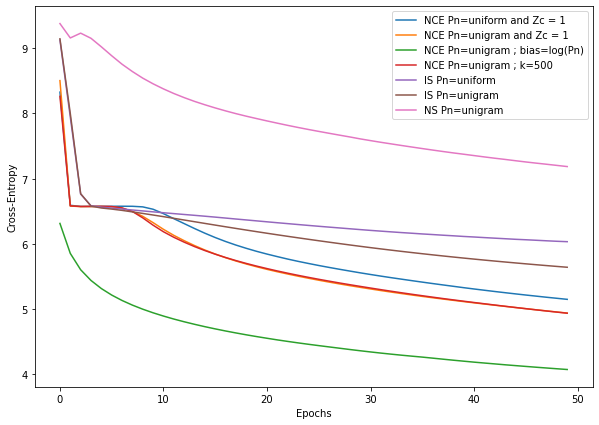

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(nce_ce_uni , label = 'NCE Pn=uniform and Zc = 1')
plt.plot(nce_ce_non_uni , label = 'NCE Pn=unigram and Zc = 1')
plt.plot(nce_ce_non_uni_bias, label = 'NCE Pn=unigram ; bias=log(Pn)')
plt.plot(nce_ce_non_uni_k500, label = 'NCE Pn=unigram ; k=500')
plt.plot(is_ce_uni, label = 'IS Pn=uniform')
plt.plot(is_ce_non_uni, label = 'IS Pn=unigram')
plt.plot(neg_ces, label = 'NS Pn=unigram')
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy")
plt.legend()
plt.show()

## NCE with trainable partition function

In [ ]:
Q = Categorical(torch.tensor(freqs))
dict_loss = {}
log_Zs = [np.log(vocab_size) , 0.0 , 5.0 , 10.0 , 15.0 , 20.0]

for logZ in log_Zs:
    model = lm(vocab_size, embed_size, hidden_size, num_layers).to(device)
    nce_loss = NCELoss(Q = Q , train_partition = True, log_Z = logZ).to(device)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(nce_loss.parameters()), lr= 1e-3)
    model, nce_ce_non_unis ,nce_non_uni_parts = train(model,
                                                      optimizer,
                                                      nce_loss, 
                                                      (train_sentences, train_masks , batch_size))
    
    dict_loss[str(logZ)] = (nce_ce_non_unis , nce_non_uni_parts)
    print('-----------------------------------------------------')

Epoch [1/50], Loss: 0.2574, Perplexity: 1474.40, CE 7.2960, Normalization 1 ?= : 0.97, Duration : 0.63
Epoch [2/50], Loss: -0.0764, Perplexity: 608.53, CE 6.4110, Normalization 1 ?= : 0.99, Duration : 0.63
Epoch [3/50], Loss: -0.1895, Perplexity: 486.76, CE 6.1878, Normalization 1 ?= : 1.00, Duration : 0.63
Epoch [4/50], Loss: -0.2503, Perplexity: 402.45, CE 5.9976, Normalization 1 ?= : 1.00, Duration : 0.63
Epoch [5/50], Loss: -0.2693, Perplexity: 346.25, CE 5.8472, Normalization 1 ?= : 1.00, Duration : 0.63
Epoch [6/50], Loss: -0.2748, Perplexity: 307.64, CE 5.7289, Normalization 1 ?= : 1.00, Duration : 0.63
Epoch [7/50], Loss: -0.2851, Perplexity: 279.52, CE 5.6331, Normalization 1 ?= : 1.00, Duration : 0.62
Epoch [8/50], Loss: -0.2904, Perplexity: 257.59, CE 5.5514, Normalization 1 ?= : 1.00, Duration : 0.63
Epoch [9/50], Loss: -0.2898, Perplexity: 239.93, CE 5.4803, Normalization 1 ?= : 1.00, Duration : 0.63
Epoch [10/50], Loss: -0.2895, Perplexity: 225.32, CE 5.4175, Normalizatio

## Plot the loss

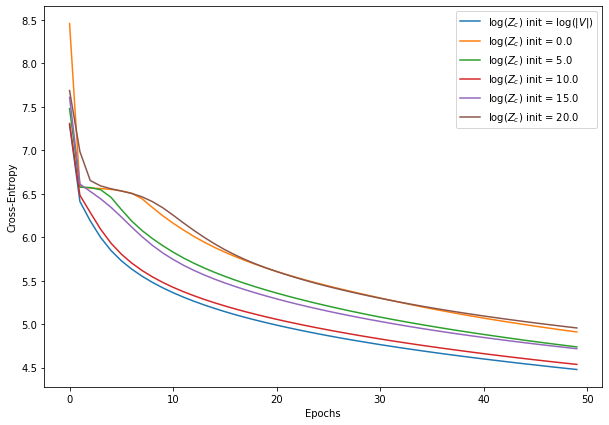

In [ ]:
plt.figure(figsize=(10,7))

k = 0
for logZ_key, tup in dict_loss.items():
    if k==0 :
        plt.plot(tup[0] , label = '$\log (Z_c)$ init = $\log(|V|)$')
    else :
        plt.plot(tup[0] , label = '$\log (Z_c)$ init = ' + str(logZ_key))
    k = k + 1

plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy")
plt.legend()
plt.show()